# CodeLab 3 - Реализация сверточной нейронной сети LeNet на Keras


В этом задании вам предстоит:

- изучить API Keras для создания и обучения нейросети (классификатора изображений);  
- подобрать архитектуру сети и гиперпараметры для получения accuracy > 0.8

In [5]:
#Импорт библиотек
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Загрузка датасета CIFAR-10 и нормализация данных

In [14]:
# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


In [15]:
# Для сверточных сетей оставляем shape=(32,32,3), изменяем только формат данных uint8 -> fp64
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.flatten()
y_test = y_test.flatten()
# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
print('Training label shape: ', y_train.shape)
print('Test label shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Training label shape:  (50000,)
Test label shape:  (10000,)


In [16]:
# Разделим данные на выборки train, val, test
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 16

# Для валидации используем подвыборку train
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# На остальных данных из train будем тренировать модель
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Чтобы ускорить разработку, создадим также небольшую dev выборку 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Для тестирования используем оригинальную выборку test
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


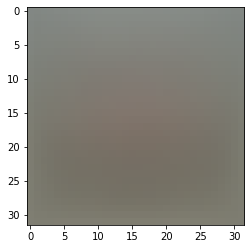

(49000, 32, 32, 3) (1000, 32, 32, 3) (1000, 32, 32, 3) (16, 32, 32, 3)


In [17]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## LeNet architecture

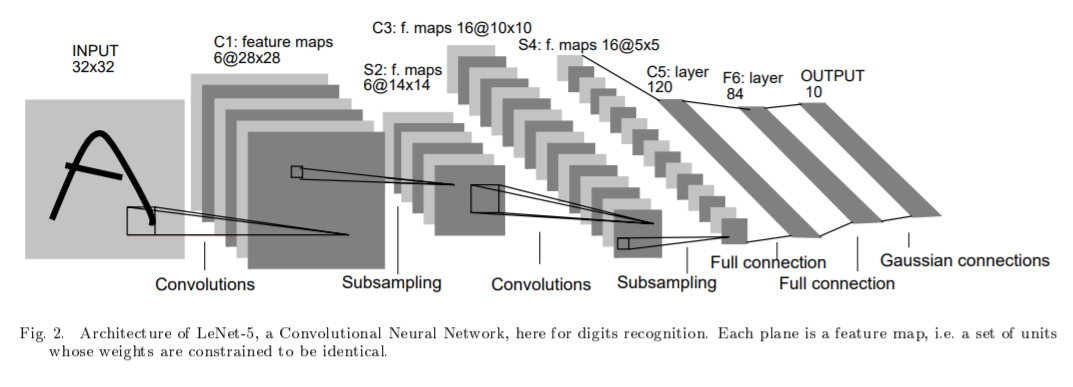

In [20]:
# Create LeNet instance
IMAGE_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

lenet = models.Sequential()
lenet.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', 
                        input_shape=IMAGE_SHAPE, padding="same"))
lenet.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
lenet.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation='tanh'))
lenet.add(layers.Dense(NUM_CLASSES, activation='softmax'))    
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD')

## Переобучим LeNet на малой выборке

In [22]:
# transform y indexes to sparse representation: [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_dev_sparse = keras.utils.to_categorical(y_dev, num_classes=NUM_CLASSES)

# Check initial loss and overfitting model with small dev dataset
hist = lenet.fit(X_dev, y_dev_sparse, batch_size=32, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 1.1128
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0401
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9670
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9263
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9292
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.8406
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.7764
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7253
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6824
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6439


## Обучение LeNet на датасете Cifar10 c гиперпараметрами по умолчанию

In [23]:
BS = 64
LR = 1e-4
EPOCHS = 8

optimizer = keras.optimizers.Adam(learning_rate=LR)
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

y_train_sparse = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
history = lenet.fit(X_train, y_train_sparse, validation_split=0.2, batch_size=BS, epochs=EPOCHS)

Epoch 1/8
613/613 [==============================] - 3s 5ms/step - loss: 1.9074 - accuracy: 0.3212 - val_loss: 1.8181 - val_accuracy: 0.3626
Epoch 2/8
613/613 [==============================] - 3s 4ms/step - loss: 1.7524 - accuracy: 0.3906 - val_loss: 1.7602 - val_accuracy: 0.3882
Epoch 3/8
613/613 [==============================] - 2s 4ms/step - loss: 1.6952 - accuracy: 0.4120 - val_loss: 1.7251 - val_accuracy: 0.4032
Epoch 4/8
613/613 [==============================] - 2s 4ms/step - loss: 1.6557 - accuracy: 0.4286 - val_loss: 1.6976 - val_accuracy: 0.4163
Epoch 5/8
613/613 [==============================] - 2s 4ms/step - loss: 1.6215 - accuracy: 0.4410 - val_loss: 1.6748 - val_accuracy: 0.4190
Epoch 6/8
613/613 [==============================] - 3s 4ms/step - loss: 1.5917 - accuracy: 0.4527 - val_loss: 1.6530 - val_accuracy: 0.4316
Epoch 7/8
613/613 [==============================] - 3s 4ms/step - loss: 1.5624 - accuracy: 0.4650 - val_loss: 1.6300 - val_accuracy: 0.4357
Epoch 8/8
613

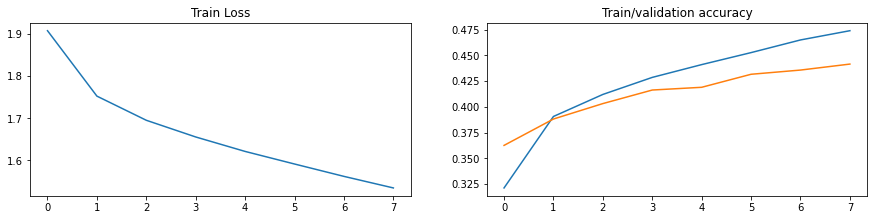

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

## Подбор архитектуры собственной сети и гиперпараметров обучения
Как видно из графиков, модель переобучилась. Поэкспериментируйте с гиперпараметрами и архитектурой, чтобы получить точность на тесте больше 80%

In [49]:
# Experiment here!
class eliseevNet(models.Sequential):
    def __init__(self, img_shape, num_classes, lr):
        super().__init__()
        #feature extractor
        self.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape, padding='same'))
        self.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
        self.add(layers.MaxPooling2D(2, 2))
        self.add(layers.Dropout(0.2))
        self.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        self.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        self.add(layers.MaxPooling2D(2, 2))
        self.add(layers.Dropout(0.2))
        self.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        self.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        self.add(layers.MaxPooling2D(2, 2))
        self.add(layers.Dropout(0.2))
        self.add(layers.Flatten())
        #classifier
        self.add(layers.Dense(128, activation='relu')) 
        self.add(layers.Dropout(0.1))
        self.add(layers.Dense(128, activation='relu'))
        self.add(layers.Dropout(0.1))
        self.add(layers.Dense(num_classes, activation='softmax'))   
        self.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

In [50]:
IMG = (32, 32, 3) #размеры изображения
NUM = 10 #число классов изображения
BS = 32 #размер входных пакетов
EP = 100 #число эпох
LR = 1e-4 #скорость обучения
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoints/best', 
                                                        monitor='val_accuracy', 
                                                        save_best_only=True, 
                                                        save_weights_only=True) #сохраняем наилучшие веса по метрике "val_accuracy"
stop_early = EarlyStopping(monitor='val_accuracy', 
                           patience=15) #если "val_accuracy" не улучашется после 15 эпохи подряд, то конец обучения

def multiclass_accuracy(y_pred, y_true):
  return np.mean(np.equal(y_true, np.argmax(y_pred, axis=1)))

neur = eliseevNet(IMG, NUM, LR)
neur.fit(X_train, y_train_sparse, 
         batch_size=BS, 
         epochs=EP,  
         validation_data=(X_val, tf.keras.utils.to_categorical(y_val)), #проверем точность на ранее созданных валидационных выборках "X_val и y_val"
         callbacks=[stop_early, checkpoint])

y_val_pred = neur.predict(X_val)
test_accuracy_val = multiclass_accuracy(y_val_pred, y_val) #точность на валидационной выборке

y_test_pred = neur.predict(X_test)
test_accuracy = multiclass_accuracy(y_test_pred, y_test) #точность на тестовой выборке

print('LeNet validation set accuracy: %f' % (test_accuracy_val, ))
print('LeNet test set accuracy: %f' % (test_accuracy, ))
assert test_accuracy > 0.8 #условие успешного выполнения ячейки

Epoch 1/100
1532/1532 [==============================] - 9s 5ms/step - loss: 2.2134 - accuracy: 0.2039 - val_loss: 1.7877 - val_accuracy: 0.3460
Epoch 2/100
1532/1532 [==============================] - 8s 5ms/step - loss: 1.7238 - accuracy: 0.3556 - val_loss: 1.5520 - val_accuracy: 0.4570
Epoch 3/100
1532/1532 [==============================] - 8s 5ms/step - loss: 1.5427 - accuracy: 0.4310 - val_loss: 1.3899 - val_accuracy: 0.5300
Epoch 4/100
1532/1532 [==============================] - 9s 6ms/step - loss: 1.4205 - accuracy: 0.4822 - val_loss: 1.3107 - val_accuracy: 0.5330
Epoch 5/100
1532/1532 [==============================] - 8s 5ms/step - loss: 1.3213 - accuracy: 0.5246 - val_loss: 1.1665 - val_accuracy: 0.6110
Epoch 6/100
1532/1532 [==============================] - 8s 5ms/step - loss: 1.2408 - accuracy: 0.5561 - val_loss: 1.1227 - val_accuracy: 0.6170
Epoch 7/100
1532/1532 [==============================] - 8s 5ms/step - loss: 1.1588 - accuracy: 0.5891 - val_loss: 1.1029 - val_ac